In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import torch
from torch import nn
from torch.utils.data import DataLoader, Dataset
import torchvision
from torchvision import transforms
from torchvision.datasets import ImageFolder
from torchinfo import summary
from PIL import Image

In [ ]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
device

In [3]:
import os
from pathlib import Path

data_path = Path("Data/food-101/")
image_path = data_path / "food-101"
print(image_path)

Data\food-101\food-101


In [4]:
print("Input file: ")
print(os.listdir(image_path))

Input file: 
['.DS_Store', 'images', 'license_agreement.txt', 'meta', 'README.txt']


In [5]:
print(f"Meta file: {os.listdir(image_path / 'meta')}")
print(f"Imgs file: {os.listdir(image_path / 'images')}")


Meta file: ['classes.txt', 'labels.txt', 'test.json', 'test.txt', 'train.json', 'train.txt']
Imgs file: ['.DS_Store', 'apple_pie', 'baby_back_ribs', 'baklava', 'beef_carpaccio', 'beef_tartare', 'beet_salad', 'beignets', 'bibimbap', 'bread_pudding', 'breakfast_burrito', 'bruschetta', 'caesar_salad', 'cannoli', 'caprese_salad', 'carrot_cake', 'ceviche', 'cheesecake', 'cheese_plate', 'chicken_curry', 'chicken_quesadilla', 'chicken_wings', 'chocolate_cake', 'chocolate_mousse', 'churros', 'clam_chowder', 'club_sandwich', 'crab_cakes', 'creme_brulee', 'croque_madame', 'cup_cakes', 'deviled_eggs', 'donuts', 'dumplings', 'edamame', 'eggs_benedict', 'escargots', 'falafel', 'filet_mignon', 'fish_and_chips', 'foie_gras', 'french_fries', 'french_onion_soup', 'french_toast', 'fried_calamari', 'fried_rice', 'frozen_yogurt', 'garlic_bread', 'gnocchi', 'greek_salad', 'grilled_cheese_sandwich', 'grilled_salmon', 'guacamole', 'gyoza', 'hamburger', 'hot_and_sour_soup', 'hot_dog', 'huevos_rancheros', 'hum

In [6]:
class_names = open(f"{image_path / 'meta'}\\classes.txt", "r").read().splitlines()
print(f"Len of Class_names: {len(class_names)}")
class_names[:5]

Len of Class_names: 101


['apple_pie', 'baby_back_ribs', 'baklava', 'beef_carpaccio', 'beef_tartare']

In [7]:
train_images = open(f"{image_path / 'meta'}\\train.txt", "r").read().splitlines()
test_images = open(f"{image_path / 'meta'}\\test.txt", "r").read().splitlines()
print(f"Length of Train Imgs: {len(train_images)}: {train_images[:5]}")
print(f"Length of Test Imgs: {len(test_images)}: {test_images[:5]}")


Length of Train Imgs: 75750: ['apple_pie/1005649', 'apple_pie/1014775', 'apple_pie/1026328', 'apple_pie/1028787', 'apple_pie/1043283']
Length of Test Imgs: 25250: ['apple_pie/1011328', 'apple_pie/101251', 'apple_pie/1034399', 'apple_pie/103801', 'apple_pie/1038694']


In [8]:
class_dic = {name: idx for idx, name in enumerate(class_names)}
class_dic

{'apple_pie': 0,
 'baby_back_ribs': 1,
 'baklava': 2,
 'beef_carpaccio': 3,
 'beef_tartare': 4,
 'beet_salad': 5,
 'beignets': 6,
 'bibimbap': 7,
 'bread_pudding': 8,
 'breakfast_burrito': 9,
 'bruschetta': 10,
 'caesar_salad': 11,
 'cannoli': 12,
 'caprese_salad': 13,
 'carrot_cake': 14,
 'ceviche': 15,
 'cheesecake': 16,
 'cheese_plate': 17,
 'chicken_curry': 18,
 'chicken_quesadilla': 19,
 'chicken_wings': 20,
 'chocolate_cake': 21,
 'chocolate_mousse': 22,
 'churros': 23,
 'clam_chowder': 24,
 'club_sandwich': 25,
 'crab_cakes': 26,
 'creme_brulee': 27,
 'croque_madame': 28,
 'cup_cakes': 29,
 'deviled_eggs': 30,
 'donuts': 31,
 'dumplings': 32,
 'edamame': 33,
 'eggs_benedict': 34,
 'escargots': 35,
 'falafel': 36,
 'filet_mignon': 37,
 'fish_and_chips': 38,
 'foie_gras': 39,
 'french_fries': 40,
 'french_onion_soup': 41,
 'french_toast': 42,
 'fried_calamari': 43,
 'fried_rice': 44,
 'frozen_yogurt': 45,
 'garlic_bread': 46,
 'gnocchi': 47,
 'greek_salad': 48,
 'grilled_cheese_sa

In [ ]:
from sklearn.utils import shuffle
def pred_df(path: str) -> pd.DataFrame:
    array = open(path, "r").read().splitlines()
    # Getting full path for image
    image_path = "Data/food-101/food-101/images/"
    full_path = [image_path + img + ".jpg" for img in array]

    imgs = []
    for img in array:
        img = img.split('/')
        imgs.append(img)
    imgs = np.array(imgs)
    labels = [img.split('/')[0] for img in array]
    # imgs = pd.DataFrame(imgs[:, 0], imgs[:,1], columns=['label'])
    imgs = pd.DataFrame({
        'path': full_path,
        'label': labels,
        'label_idx': [class_dic[label] for label in labels]  # Thêm chỉ số nhãn
    })     
    # Adding the full path to the data frame
    imgs['path'] = full_path

    # Randomly shuffling the order of the data in the dataframe
    imgs = shuffle(imgs)

    return imgs

In [10]:
train_dir = image_path / "meta/train.txt"
test_dir = image_path / "meta/test.txt"
train_imgs = pred_df(train_dir)
test_imgs = pred_df(test_dir)
train_imgs.groupby(["label"]).count()

,path,label_idx
label,,
apple_pie,750,750
baby_back_ribs,750,750
baklava,750,750
beef_carpaccio,750,750
beef_tartare,750,750
...,...,...
tacos,750,750
takoyaki,750,750
tiramisu,750,750


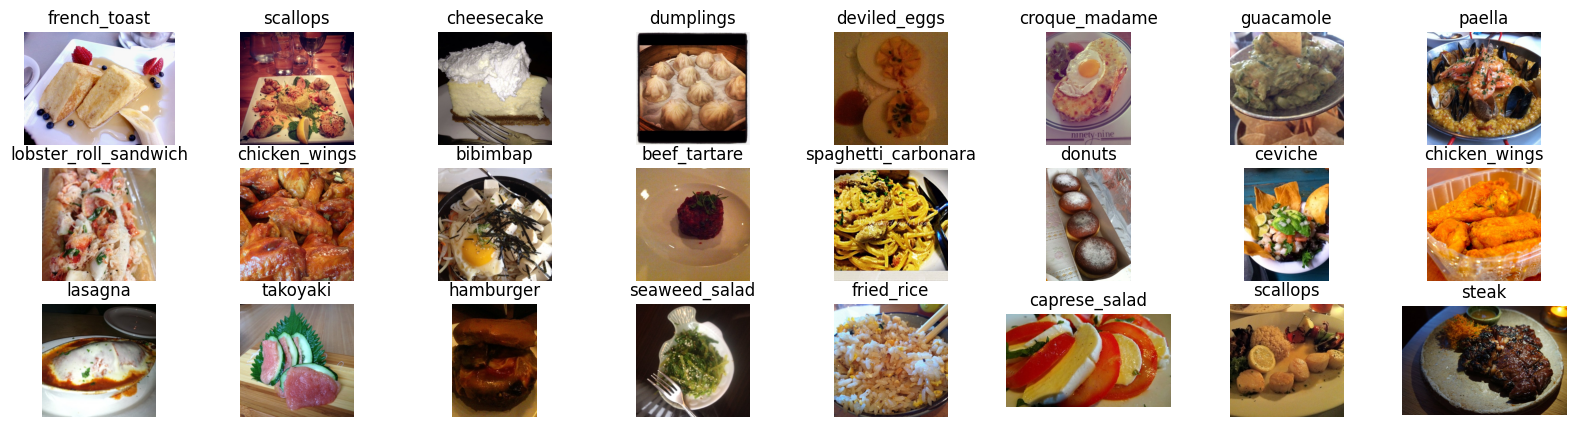

In [11]:
plt.figure(figsize=(20, 5))

num_rows = 3
num_cols = 8


for idx in range(num_rows * num_cols):
    random_idx = np.random.randint(0, train_imgs.shape[0])
    img = plt.imread(train_imgs.path.iloc[random_idx])

    label = train_imgs.label.iloc[random_idx]

    ax = plt.subplot(num_rows, num_cols, idx + 1)
    plt.imshow(img)
    plt.title(label)
    plt.axis("off")

In [ ]:
## Data_Setup
# train_transform = transforms.Compose([
#     transforms.Resize((224, 224)),
#     transforms.ToTensor(),
#     transforms.Normalize((0.48145466, 0.4578275, 0.40821073), (0.26862954, 0.26130258, 0.27577711))
# ])



# test_transform = transforms.Compose([
#     transforms.Resize((224, 224)),
#     transforms.ToTensor(),
#     transforms.Normalize((0.48145466, 0.4578275, 0.40821073), (0.26862954, 0.26130258, 0.27577711))
# ])

from torchvision.transforms.autoaugment import AutoAugmentPolicy
class CutOut(object):
    def __init__(self, mask_size, p=0.5):
        self.mask_size = mask_size
        self.p = p

    def __call__(self, img):
        if torch.rand(1).item() > self.p:
            return img

        h, w = img.size(-2), img.size(-1)
        y = torch.randint(0, h, (1,)).item()
        x = torch.randint(0, w, (1,)).item()

        y1 = max(0, y - self.mask_size // 2)
        y2 = min(h, y + self.mask_size // 2)
        x1 = max(0, x - self.mask_size // 2)
        x2 = min(w, x + self.mask_size // 2)

        img[:, y1:y2, x1:x2] = 0
        return img

train_transform = transforms.Compose([
    transforms.RandomRotation(45),  
    transforms.RandomResizedCrop(224),
    transforms.RandomHorizontalFlip(p=0.7),  
    transforms.AutoAugment(policy=AutoAugmentPolicy.IMAGENET), 
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2), 
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]),
    CutOut(mask_size=20, p=0.5)
])


test_transform = transforms.Compose([
    transforms.Resize(255),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])
    

In [13]:
train_imgs

,path,label,label_idx
47995,Data/food-101/food-101/images/macarons/990832.jpg,macarons,63
63507,Data/food-101/food-101/images/risotto/3397285.jpg,risotto,84
39543,Data/food-101/food-101/images/gyoza/3623236.jpg,gyoza,52
69802,Data/food-101/food-101/images/steak/1340977.jpg,steak,93
74009,Data/food-101/food-101/images/tiramisu/33703.jpg,tiramisu,98
...,...,...,...
52988,Data/food-101/food-101/images/pad_thai/3196826...,pad_thai,70
17832,Data/food-101/food-101/images/churros/371224.jpg,churros,23
13139,Data/food-101/food-101/images/cheese_plate/281...,cheese_plate,17
30127,Data/food-101/food-101/images/french_fries/169...,french_fries,40


In [ ]:
class FoodDataset(Dataset):
    def __init__(self, dataframe, transform=None):
        self.dataframe = dataframe
        self.transform = transform

    def __len__(self):
        return self.dataframe.shape[0]

    def __getitem__(self, idx):
        img_name = self.dataframe.path.iloc[idx]
        label = self.dataframe['label_idx'].iloc[idx]
        image = Image.open(img_name)
        if image.mode != 'RGB':
            image = image.convert('RGB')
        # label = encoder_21.get_idx(self.dataframe.label.iloc[idx])
        # label = class_dic[img_name]
        # print(label)
        if self.transform:
            image = self.transform(image)
        return image, label
train_dataset = FoodDataset(train_imgs, transform=train_transform)
test_dataset = FoodDataset(test_imgs, transform=test_transform)
train_dataset

In [15]:
BATCH_SIZE = 32
NUM_WORKERS = 0 #os.cpu_count()

train_dataloader = DataLoader(
    train_dataset,
    batch_size=BATCH_SIZE,
    shuffle=True,
    num_workers=NUM_WORKERS,
    pin_memory=True
)

test_dataloader = DataLoader(
    test_dataset,
    batch_size=BATCH_SIZE,
    num_workers=NUM_WORKERS,
    shuffle=False,
    pin_memory=True
)


In [16]:
print(f"\nNumber of training batches: {len(train_dataloader)}")
print(f"Number of test batches: {len(test_dataloader)}")



Number of training batches: 2368
Number of test batches: 790


In [17]:
import clip 
model, preprocess = clip.load("ViT-B/32", jit=False)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)


CLIP(
  (visual): VisionTransformer(
    (conv1): Conv2d(3, 768, kernel_size=(32, 32), stride=(32, 32), bias=False)
    (ln_pre): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
    (transformer): Transformer(
      (resblocks): Sequential(
        (0): ResidualAttentionBlock(
          (attn): MultiheadAttention(
            (out_proj): NonDynamicallyQuantizableLinear(in_features=768, out_features=768, bias=True)
          )
          (ln_1): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
          (mlp): Sequential(
            (c_fc): Linear(in_features=768, out_features=3072, bias=True)
            (gelu): QuickGELU()
            (c_proj): Linear(in_features=3072, out_features=768, bias=True)
          )
          (ln_2): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
        )
        (1): ResidualAttentionBlock(
          (attn): MultiheadAttention(
            (out_proj): NonDynamicallyQuantizableLinear(in_features=768, out_features=768, bias=True)
          

In [18]:
summary(
    model=model.visual,
    input_size=(32, 3, 224, 224),
    dtypes=[torch.float16],
    col_names=["input_size", "output_size", "num_params", "trainable"],
    col_width=20,
    row_settings=["var_names"]
)

c:\Users\AnhTai310104\AppData\Local\Programs\Python\Python39\lib\site-packages\torchinfo\torchinfo.py:216: UserWarning: Half precision is not supported with input_size parameter, and may output incorrect results. Try passing input_data directly.
  validate_user_params(


Layer (type (var_name))                            Input Shape          Output Shape         Param #              Trainable
VisionTransformer (VisionTransformer)              [32, 3, 224, 224]    [32, 512]            432,384              True
├─Conv2d (conv1)                                   [32, 3, 224, 224]    [32, 768, 7, 7]      2,359,296            True
├─LayerNorm (ln_pre)                               [32, 50, 768]        [32, 50, 768]        1,536                True
├─Transformer (transformer)                        [50, 32, 768]        [50, 32, 768]        --                   True
│    └─Sequential (resblocks)                      [50, 32, 768]        [50, 32, 768]        --                   True
│    │    └─ResidualAttentionBlock (0)             [50, 32, 768]        [50, 32, 768]        7,087,872            True
│    │    └─ResidualAttentionBlock (1)             [50, 32, 768]        [50, 32, 768]        7,087,872            True
│    │    └─ResidualAttentionBlock (2)     

In [19]:
# # Modify the model to include a classifier for subcategories
# class CLIPFineTuner(nn.Module):
#     def __init__(self, model, num_classes):
#         super(CLIPFineTuner, self).__init__()
#         self.model = model
#         self.classifier = nn.Linear(model.visual.output_dim, num_classes)
    
#     def forward(self, x):
#         with torch.no_grad():
#             features = self.model.encode_image(x).float()  # Convert to float32
#         return self.classifier(features)

In [20]:
for param in model.visual.parameters():
    param.requires_grad = False

In [ ]:
num_classes = len(class_names)
class CLIPFineTuner(nn.Module):
    def __init__(self, model, num_classes):
        super(CLIPFineTuner, self).__init__()
        self.model = model
        self.classifier = nn.Sequential(
            nn.Dropout(p=0.2, inplace=True),
            nn.Linear(model.visual.output_dim, num_classes)
        )
    
    def forward(self, x):
        with torch.no_grad():
            features = self.model.encode_image(x).float()  # Convert to float32
        return self.classifier(features)

In [22]:
model_ft = CLIPFineTuner(model, num_classes).to(device)


In [23]:
summary(
    model=model_ft,
    input_size=(32, 3, 224, 224),
    dtypes=[torch.float16],
    col_names=["input_size", "output_size", "num_params", "trainable"],
    col_width=20,
    row_settings=["var_names"],
    verbose=0
)

Layer (type (var_name))                                      Input Shape          Output Shape         Param #              Trainable
CLIPFineTuner (CLIPFineTuner)                                [32, 3, 224, 224]    [32, 101]            --                   Partial
├─CLIP (model)                                               --                   --                   63,428,097           Partial
│    └─VisionTransformer (visual)                            [32, 3, 224, 224]    [32, 512]            432,384              False
│    │    └─Conv2d (conv1)                                   [32, 3, 224, 224]    [32, 768, 7, 7]      (2,359,296)          False
│    │    └─LayerNorm (ln_pre)                               [32, 50, 768]        [32, 50, 768]        (1,536)              False
│    │    └─Transformer (transformer)                        [50, 32, 768]        [50, 32, 768]        (85,054,464)         False
│    │    └─LayerNorm (ln_post)                              [32, 768]            

In [24]:
# Define the loss function and optimizer
from torch import optim
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model_ft.classifier.parameters(), lr=1e-4)

In [ ]:
from tqdm import tqdm
from typing import Dict, List, Tuple

num_epochs = 5
def train_step(model: torch.nn.Module, 
               dataloader: torch.utils.data.DataLoader, 
               criterion: torch.nn.Module, 
               optimizer: torch.optim.Optimizer,
               device: torch.device,
               epoch: int) -> Tuple[float, float]:
    pbar = tqdm(dataloader, desc=f"Epoch {epoch+1}/{num_epochs}, Loss: 0.0000")  # Initialize progress bar
    model.train()
    train_loss, train_acc = 0, 0
    total, correct = 0, 0
    for images, labels in pbar: #dataloader:
        images, labels = images.to(device), labels.to(device) 
        label_pred = model(images)
        loss = criterion(label_pred, labels)
        train_loss += loss
        optimizer.zero_grad() 
        loss.backward()  
        optimizer.step()  
        # label_pred_class = torch.argmax(torch.softmax(label_pred, dim=1), dim=1)
        _, predicted = torch.max(label_pred.data, 1)
        # train_loss += loss.item()  # Update running loss
        # train_acc += (label_pred_class == labels).sum().item()/len(label_pred)
        total += labels.size(0)  # Update total samples
        correct += (predicted == labels).sum().item()
        pbar.set_description(f"Epoch {epoch+1}/{num_epochs}, Loss: {train_loss/len(dataloader):.4f}")  # Update progress bar with current loss
    print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {train_loss/len(dataloader):.4f}')  # Print average loss for the epoch

    train_loss = train_loss / len(dataloader)
    train_acc = 100 * correct / total
    return train_loss, train_acc

def test_step(model: torch.nn.Module, 
              dataloader: torch.utils.data.DataLoader, 
              criterion: torch.nn.Module,
              device: torch.device) -> Tuple[float, float]:
    model.eval()
    test_loss, test_acc = 0, 0
    correct = 0  
    total = 0 
    with torch.no_grad():  # Disable gradient calculation for validation
        for images, labels in dataloader:
            images, labels = images.to(device), labels.to(device) 
            outputs = model(images)  # Forward pass: compute predicted outputs by passing inputs to the model
            loss = criterion(outputs, labels)
            test_loss += loss
            _, predicted = torch.max(outputs.data, 1)  # Get the class label with the highest probability
            total += labels.size(0)  # Update total samples
            correct += (predicted == labels).sum().item() 
    test_loss /= len(dataloader)
    test_acc = 100 * correct / total
    return test_loss, test_acc

def train(model: torch.nn.Module, 
          train_dataloader: torch.utils.data.DataLoader, 
          test_dataloader: torch.utils.data.DataLoader, 
          optimizer: torch.optim.Optimizer,
          criterion: torch.nn.Module,
          epochs: int,
          device: torch.device) -> Dict[str, List]:
    results = {"train_loss": [],
      "train_acc": [],
      "test_loss": [],
      "test_acc": []
    }
    for epoch in range(epochs):
      train_loss, train_acc = train_step(model=model,
                                          dataloader=train_dataloader,
                                          criterion=criterion,
                                          optimizer=optimizer,
                                          device=device,
                                          epoch=epoch)
      test_loss, test_acc = test_step(model=model,
          dataloader=test_dataloader,
          criterion=criterion,
          device=device)

      # Print out what's happening
      print(
          f"Epoch: {epoch+1} | "
          f"train_loss: {train_loss:.4f} | "
          f"train_acc: {train_acc:.4f} | "
          f"test_loss: {test_loss:.4f} | "
          f"test_acc: {test_acc:.4f}"
      )

      # Update results dictionary
      results["train_loss"].append(train_loss)
      results["train_acc"].append(train_acc)
      results["test_loss"].append(test_loss)
      results["test_acc"].append(test_acc)
      
    torch.save(model.state_dict(), 'clip_finetuned.pth')
  
    return results
# Training loop
# for epoch in range(num_epochs):
#     model_ft.train()  # Set the model to training mode
#     running_loss = 0.0  # Initialize running loss for the current epoch
#     pbar = tqdm(train_dataloader, desc=f"Epoch {epoch+1}/{num_epochs}, Loss: 0.0000")  # Initialize progress bar
    
#     for images, labels in pbar:
#         images, labels = images.to(device), labels.to(device)  # Move images and labels to the device (GPU or CPU)
#         optimizer.zero_grad()  # Clear the gradients of all optimized variables
#         outputs = model_ft(images)  # Forward pass: compute predicted outputs by passing inputs to the model
#         loss = criterion(outputs, labels)  
#         loss.backward()  
#         optimizer.step()  
        
#         running_loss += loss.item()  # Update running loss
#         pbar.set_description(f"Epoch {epoch+1}/{num_epochs}, Loss: {running_loss/len(train_dataloader):.4f}")  # Update progress bar with current loss

#     print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {running_loss/len(train_dataloader):.4f}')  # Print average loss for the epoch
#     
#     # Validation
#     model_ft.eval()  
#     correct = 0  
#     total = 0 
    
#     with torch.no_grad():  # Disable gradient calculation for validation
#         for images, labels in test_dataloader:
#             images, labels = images.to(device), labels.to(device)  # Move images and labels to the device
#             outputs = model_ft(images)  # Forward pass: compute predicted outputs by passing inputs to the model
#             _, predicted = torch.max(outputs.data, 1)  # Get the class label with the highest probability
#             total += labels.size(0)  # Update total samples
#             correct += (predicted == labels).sum().item() 

#     print(f'Validation Accuracy: {100 * correct / total}%') 

# # Save the fine-tuned model
# torch.save(model_ft.state_dict(), 'clip_finetuned.pth')  # Save the model's state dictionary


In [26]:
model_ft_results = train(model=model_ft, 
                        train_dataloader=train_dataloader,
                        test_dataloader=test_dataloader,
                        optimizer=optimizer,
                        criterion=criterion, 
                        epochs=num_epochs,device=device)


Epoch 1/5, Loss: 4.0268: 100%|██████████| 2368/2368 [12:02<00:00,  3.28it/s]


Epoch [1/5], Loss: 4.0268
Epoch: 1 | train_loss: 4.0268 | train_acc: 25.0970 | test_loss: 2.6847 | test_acc: 70.9822


Epoch 2/5, Loss: 3.1842: 100%|██████████| 2368/2368 [12:00<00:00,  3.29it/s]


Epoch [2/5], Loss: 3.1842
Epoch: 2 | train_loss: 3.1842 | train_acc: 41.2884 | test_loss: 1.7129 | test_acc: 77.8099


Epoch 3/5, Loss: 2.7624: 100%|██████████| 2368/2368 [11:52<00:00,  3.32it/s]


Epoch [3/5], Loss: 2.7624
Epoch: 3 | train_loss: 2.7624 | train_acc: 44.8950 | test_loss: 1.2560 | test_acc: 80.7802


Epoch 4/5, Loss: 2.5504: 100%|██████████| 2368/2368 [12:26<00:00,  3.17it/s]


Epoch [4/5], Loss: 2.5504
Epoch: 4 | train_loss: 2.5504 | train_acc: 46.2310 | test_loss: 1.0180 | test_acc: 82.4000


Epoch 5/5, Loss: 2.4242: 100%|██████████| 2368/2368 [12:43<00:00,  3.10it/s]


Epoch [5/5], Loss: 2.4242
Epoch: 5 | train_loss: 2.4242 | train_acc: 47.1960 | test_loss: 0.8844 | test_acc: 82.9545


In [42]:
model_ft_results

{'train_loss': [tensor(4.0268, device='cuda:0', grad_fn=<DivBackward0>),
  tensor(3.1842, device='cuda:0', grad_fn=<DivBackward0>),
  tensor(2.7624, device='cuda:0', grad_fn=<DivBackward0>),
  tensor(2.5504, device='cuda:0', grad_fn=<DivBackward0>),
  tensor(2.4242, device='cuda:0', grad_fn=<DivBackward0>)],
 'train_acc': [25.097029702970296,
  41.28844884488449,
  44.89504950495049,
  46.23102310231023,
  47.19603960396039],
 'test_loss': [tensor(2.6847, device='cuda:0'),
  tensor(1.7129, device='cuda:0'),
  tensor(1.2560, device='cuda:0'),
  tensor(1.0180, device='cuda:0'),
  tensor(0.8844, device='cuda:0')],
 'test_acc': [70.98217821782178,
  77.80990099009901,
  80.78019801980199,
  82.4,
  82.95445544554455]}

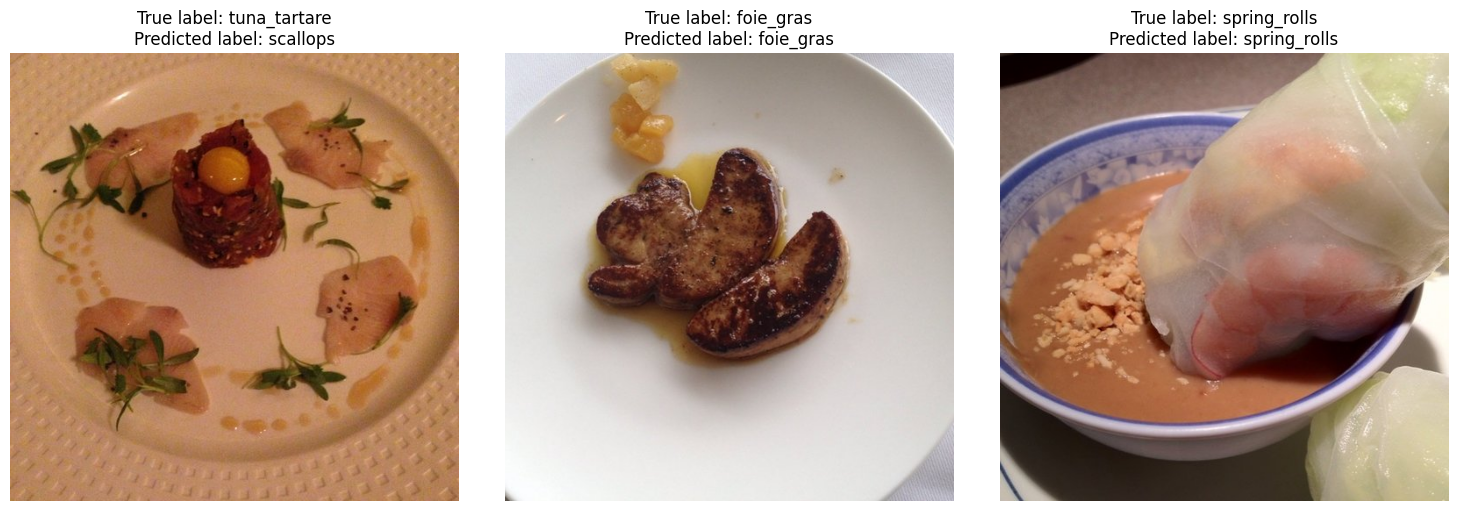

In [32]:
import matplotlib.pyplot as plt
import torch
from torchvision import transforms

model_ft.load_state_dict(torch.load('clip_finetuned.pth'))
model_ft.eval()  

indices = [0,1,2]
index_to_class = {idx: name for name, idx in class_dic.items()}
# Preprocess the image
# transform = transforms.Compose([
#     transforms.Resize((224, 224)),
#     transforms.ToTensor(),
#     transforms.Normalize((0.48145466, 0.4578275, 0.40821073), (0.26862954, 0.26130258, 0.27577711))
# ])
transform = transforms.Compose([
    transforms.Resize(255),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])


fig, axes = plt.subplots(1, 3, figsize=(15, 5))

for i, idx in enumerate(indices):
    # Get the image and label from the dataset
    item = test_imgs.iloc[idx]
    image = item['path']
    true_label = item['label']
    image = Image.open(image)
    # Transform the image
    img_tran = transform(image)
    image_tensor = transform(image).unsqueeze(0).to(device) 

    with torch.no_grad():
        output = model_ft(image_tensor)
        _, predicted_label_idx = torch.max(output, 1)
        predicted_label = index_to_class[predicted_label_idx.item()]

    axes[i].imshow(image)
    axes[i].set_title(f'True label: {true_label}\nPredicted label: {predicted_label}')
    axes[i].axis('off')


plt.tight_layout()
plt.show()


In [33]:
def pred_and_plot(model, image_path, class_dic, transform, device):
    index_to_class = {idx: name for name, idx in class_dic.items()}
    true_label = test_imgs[test_imgs['path'] == image_path]['label'].iloc[0]
    print(true_label)
    image = Image.open(image_path)
    # Transform the image
    image_tensor = transform(image).unsqueeze(0).to(device)  # Add batch dimension and move to device
    model.to(device)
    model.eval()
    with torch.no_grad():
        output = model_ft(image_tensor)
        _, predicted_label_idx = torch.max(output, 1)
        predicted_label = index_to_class[predicted_label_idx.item()]

    plt.figure()
    plt.imshow(image)
    plt.title(f"True label: {true_label}\nPredicted label: {predicted_label}")
    plt.axis('off')


pork_chop


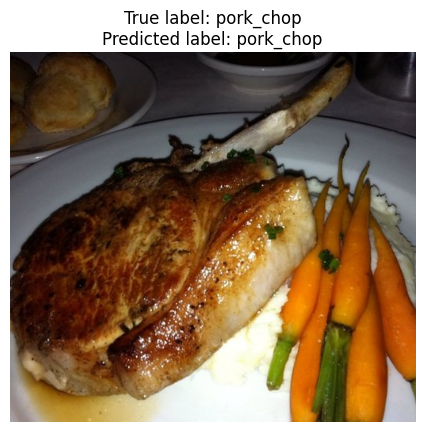

In [35]:
pred_and_plot(model_ft, test_imgs.iloc[200]['path'], class_dic, transform, device)

In [36]:

import requests
from io import BytesIO
def pred_and_plot_from_url(model, url, class_dic, transform, device):
    index_to_class = {idx: name for name, idx in class_dic.items()}

    # Tải ảnh từ URL
    response = requests.get(url, timeout=10)
    response.raise_for_status()  # Kiểm tra lỗi HTTP
    image = Image.open(BytesIO(response.content))
    if image.mode != 'RGB':
        image = image.convert('RGB')
   
    image_tensor = transform(image).unsqueeze(0).to(device)  # Thêm batch dimension
    
    model = model.to(device)
    model.eval()

    with torch.no_grad():
        output = model(image_tensor)
        _, predicted_label_idx = torch.max(output, 1)
        predicted_label = index_to_class.get(predicted_label_idx.item(), "Unknown")

    image_np = np.array(image)
    if image_np.shape[2] != 3:
        image_np = image_np[:, :, :3]

    # Hiển thị ảnh
    plt.figure()
    plt.imshow(image_np)
    plt.title(f"Predicted label: {predicted_label}")
    plt.axis('off')
    plt.show()

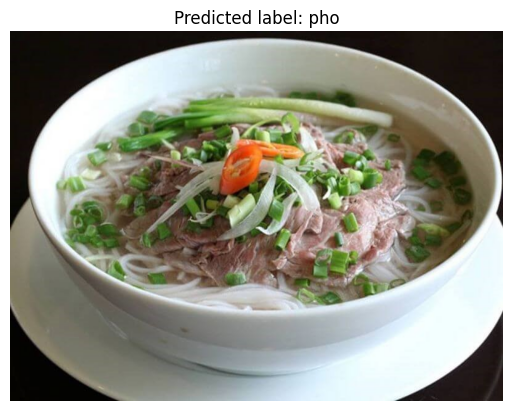

In [37]:
url = "https://vietfood.org.vn/wp-content/uploads/2020/12/Pho1.jpg"
# url = "https://encrypted-tbn0.gstatic.com/images?q=tbn:ANd9GcRAmW4TXOvSAEKudVyzdELnRImrPI3b5VuAtA&s"
# url = "https://encrypted-tbn0.gstatic.com/images?q=tbn:ANd9GcRDjrfzSMj3Y7WalwB1cA5cb0wnIT-_8sMa5g&s"
# url = "https://encrypted-tbn3.gstatic.com/images?q=tbn:ANd9GcRtd_ffQLd2xWg9iW7DaSQirddjFFVC_zr_iVcNMieE-22Vqj2IPNGc3YT4dWIeO5iPdJJfOgF_djuWRsAJnt8iGI_kVnd8Z9rWwvwJj1I"
pred_and_plot_from_url(model_ft, url, class_dic, transform, device)

In [40]:
def plot_loss_curve(results: dict[str, list[float]]):
    # train_loss = results['train_loss']
    # train_acc = results['train_acc']
    # test_loss = results['test_loss']
    # test_acc = results['test_acc']
    train_loss = [float(x.cpu()) if isinstance(x, torch.Tensor) else float(x) for x in results['train_loss']]
    train_acc = [float(x.cpu()) if isinstance(x, torch.Tensor) else float(x) for x in results['train_acc']]
    test_loss = [float(x.cpu()) if isinstance(x, torch.Tensor) else float(x) for x in results['test_loss']]
    test_acc = [float(x.cpu()) if isinstance(x, torch.Tensor) else float(x) for x in results['test_acc']]

    epochs = range(len(results['train_loss']))

    plt.figure(figsize=(10,7))
    plt.subplot(1,2,1)
    plt.plot(epochs, train_loss,c='g',label='Train loss')
    plt.plot(epochs, test_loss,c='r',label='Test loss')
    plt.title("Loss")
    plt.xlabel("Epochs")
    plt.legend()

    plt.subplot(1,2,2)
    plt.plot(epochs, train_acc,c='g',label='Train acc')
    plt.plot(epochs, test_acc,c='r',label='Test acc')
    plt.title("Acc")
    plt.xlabel("Epochs")
    plt.legend()

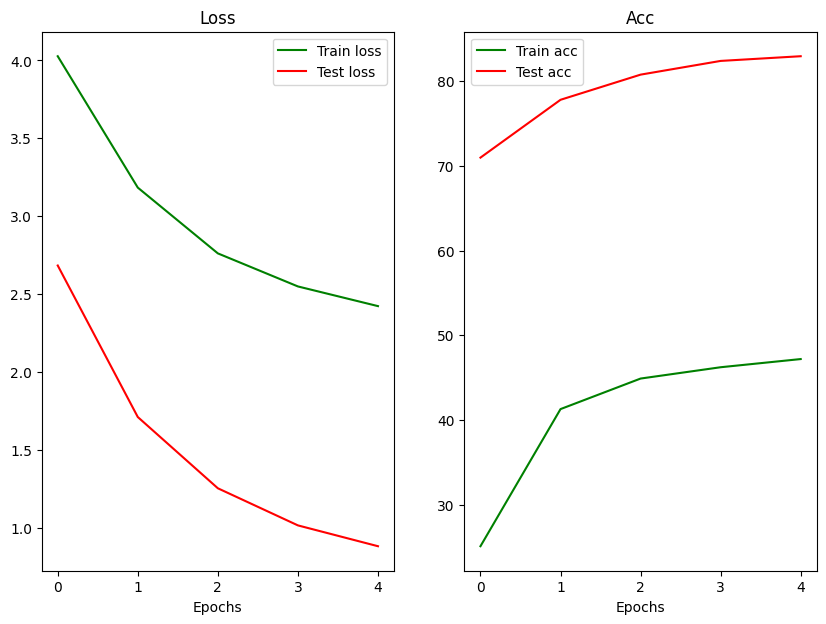

In [41]:
plot_loss_curve(model_ft_results)